In [17]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb
from scipy.stats import skew
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from datetime import date, timedelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Bidirectional
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import math

In [18]:
symbol = input("enter symbol here : ")

##### Fetch Live stock data 

In [19]:
import yfinance as yf

print(f"Fetching data for '{symbol}' using yfinance...")

try:
    # 2. Create a Ticker object
    sym_data = yf.Ticker(symbol)

    # 3. Fetch historical market data (last 60 days with 10-minute intervals)
    data = sym_data.history(period="60d", interval="5m")

    data = data.reset_index()  # Reset index to make 'Datetime' a column
    # The column name after reset_index depends on the yfinance version,
    # it could be 'Datetime' or 'index'. We'll handle 'Datetime'.
    if "Datetime" in data.columns:
        # Format the 'Datetime' column to 'YYYY-MM-DD HH:MM'
        data["Datetime"] = data["Datetime"].dt.strftime("%Y-%m-%d %H:%M")
    elif "index" in data.columns:
        data = data.rename(columns={"index": "Datetime"})
        data["Datetime"] = data["Datetime"].dt.strftime("%Y-%m-%d %H:%M")

    # We now have the 'Datetime' column to include.
    data = data[["Datetime", "Open", "High", "Low", "Close"]]

    # 7. Display the final data
    print("\nHere are the last 5 data points:")
    print(data.tail().round(2))

except Exception as e:
    print(f"\nAn error occurred: {e}")

Fetching data for 'CESC.NS' using yfinance...

Here are the last 5 data points:
              Datetime    Open    High     Low   Close
4420  2025-08-28 15:05  154.80  154.90  154.44  154.49
4421  2025-08-28 15:10  154.48  154.84  154.01  154.65
4422  2025-08-28 15:15  154.65  154.65  154.01  154.38
4423  2025-08-28 15:20  154.35  154.45  153.56  153.85
4424  2025-08-28 15:25  153.86  153.95  153.67  153.92


##### Neccesary Data pre-processing steps 

In [20]:
# Summary statistics of numerical columns
print("summary statistics  \n",data.describe().T)

summary statistics  
         count        mean       std         min         25%         50%  \
Open   4425.0  170.631026  6.619037  153.860001  164.460007  169.380005   
High   4425.0  170.819494  6.613510  153.949997  164.660004  169.570007   
Low    4425.0  170.433600  6.623183  153.559998  164.339996  169.199997   
Close  4425.0  170.628420  6.625014  153.850006  164.470001  169.389999   

              75%         max  
Open   177.320007  182.899994  
High   177.559998  183.000000  
Low    177.020004  182.539993  
Close  177.279999  182.899994  


##### Stock Price Visualization 

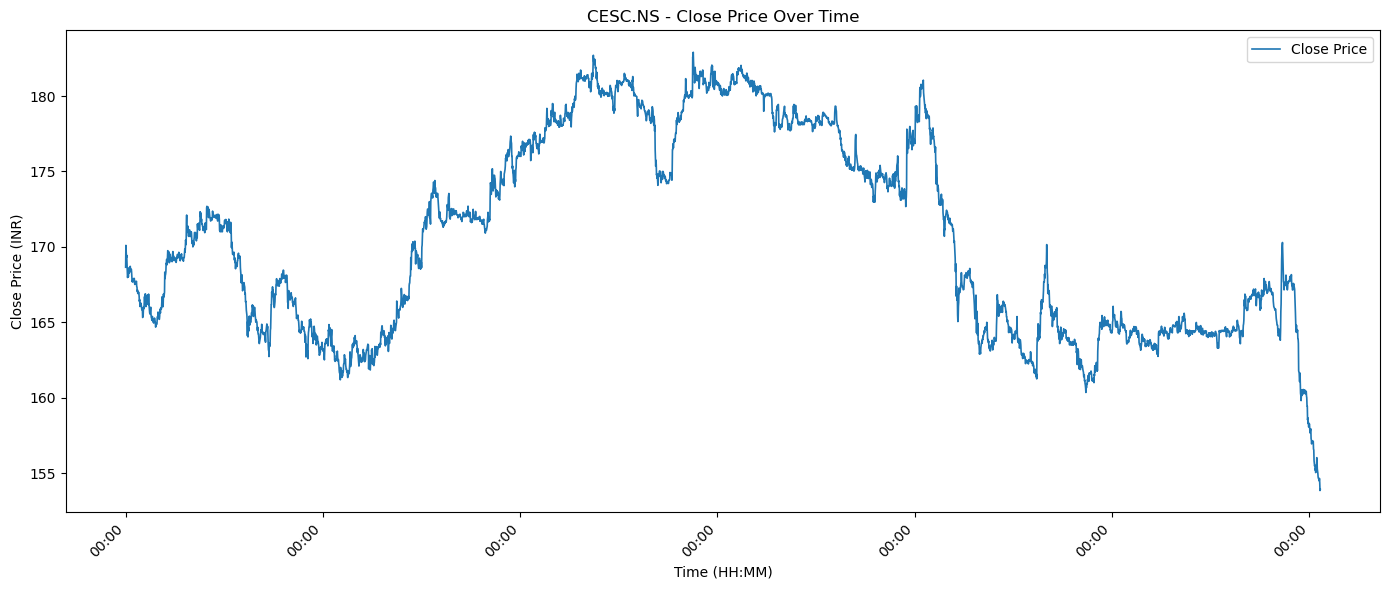

In [21]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(14, 6))
plt.plot(data["Datetime"], data["Close"], label="Close Price", linewidth=1.2)

# Convert Datetime column back to datetime objects (if it's string-formatted earlier)
data["Datetime"] = pd.to_datetime(data["Datetime"])

# Format x-axis to show only HH:MM
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

plt.xticks(rotation=45, ha="right")
plt.xlabel("Time (HH:MM)")
plt.ylabel("Close Price (INR)")
plt.title(f"{symbol} - Close Price Over Time")
plt.legend()
plt.tight_layout()
plt.show()

##### Scatter plot shows the association between two variable (how much they're depended)

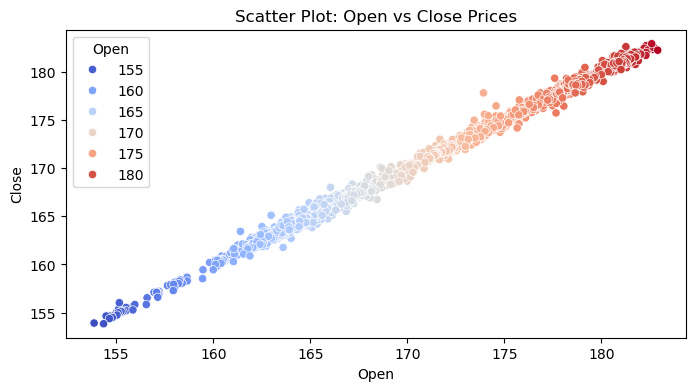

In [22]:
# Scatter plot between Open & Close prices
plt.figure(figsize=(8, 4))
sb.scatterplot(x=data['Open'], y=data['Close'], hue=data['Open'], palette='coolwarm')
plt.title("Scatter Plot: Open vs Close Prices")
plt.show()

##### Heatmap shows the correlations of all the numerical cols and shows how all are connected

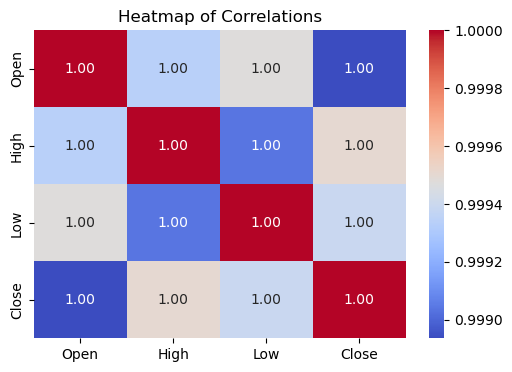

In [23]:
numeric_cols = data.select_dtypes(include=['float64', 'int64'])
# heatmap for visualizing relationships between numerical columns
plt.figure(figsize=(6, 4))
sb.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Heatmap of Correlations")
plt.show()

###### Rule of thumb:-
- 0.5 < skew < 0.5 → fairly symmetrical
- Otherwise → consider transformation

In [24]:
print("Skewness (Close):", skew(data['Close']))
print("Skewness (Open):", skew(data['Open']))
print("Skewness (High):", skew(data['High']))
print("Skewness (Low):", skew(data['Low']))

Skewness (Close): 0.18795152049993477
Skewness (Open): 0.19070462653344752
Skewness (High): 0.18540053401448228
Skewness (Low): 0.18964617435117123


#### Skewness Analysis 
- Market data or live time series data has very uneven skewness which is more common and expected due high volatility and other factors on markets

In [25]:
# Volume:
# Extremely skewed — a few trading days have unusually high volumes.
# This can cause LSTM to overemphasize rare spikes.
# Solution : Log transformation to reduce skewness.

## As of now, we are not using volume in our model, but if we do, we can apply log transformation to reduce skewness in future. 

In [26]:
## Adding a trend column to the data
# This column indicates whether the price is expected to go up (1) or down (0
data['Trend'] = (data['Close'].shift(-1) > data['Close']).astype(int)

In [27]:
print("Overview of dataset after adding some features \n\n")
data = data.round(2)  # rounding off the values for better readability
print(data.tail())

Overview of dataset after adding some features 


                Datetime    Open    High     Low   Close  Trend
4420 2025-08-28 15:05:00  154.80  154.90  154.44  154.49      1
4421 2025-08-28 15:10:00  154.48  154.84  154.01  154.65      0
4422 2025-08-28 15:15:00  154.65  154.65  154.01  154.38      0
4423 2025-08-28 15:20:00  154.35  154.45  153.56  153.85      1
4424 2025-08-28 15:25:00  153.86  153.95  153.67  153.92      0


### LSTM MODEL

##### 1️⃣ Preparing Your Data for LSTM
###### LSTMs expect 3D input: [samples, timesteps, features]
where
```
samples = number of training examples
timesteps = how many past days to look back
features = number of columns (Open, High, Low, Close, Volume)
```

Step 1: Apply transformations & scaling

In [28]:
# Scale all features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[["Open", "High", "Low", "Close"]])

Step 2: Create sequences(timesteps)

In [29]:
def create_sequences(dataset, time_steps=90):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        X.append(dataset[i:(i + time_steps)])  # past 60 days
        y.append(dataset[i + time_steps, 0])   # 'Close' is 1st column here
    # Convert to numpy arrays for better performance with LSTM
    return np.array(X), np.array(y)

time_steps = 60
X, y = create_sequences(scaled_data, time_steps)


Step 3: Train-test split (no shuffle)

In [30]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

Training data shape: (3492, 60, 4), (3492,)
Testing data shape: (873, 60, 4), (873,)


Step 4: LSTM model (Keras - RNN variant) 

In [32]:
model = Sequential()
model.add(
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))
)
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))  # Predict close price
# model.add(Bidirectional(LSTM(50, return_sequences=True, input_shape=(...))))

model.compile(optimizer="adam", loss="mean_squared_error")

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
)

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - loss: 0.0310 - val_loss: 5.5502e-04
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0043 - val_loss: 9.9547e-04
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0040 - val_loss: 5.3589e-04
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0033 - val_loss: 4.6144e-04
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0031 - val_loss: 6.0759e-04
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0032 - val_loss: 4.7098e-04
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0030 - val_loss: 4.7414e-04
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 9/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 10/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0029 - val_loss: 8.4208e-04
Epoch 11/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0026 - val_loss: 3.3674e-04
Epoc

Model evaluation metrics

In [33]:
# Predictions
y_pred = model.predict(X_test)
# Inverse transform (to get actual prices back)
# y_test and y_pred are scaled — need to bring them back

# Create empty array for inverse scaling
y_test_inv = np.zeros((len(y_test), scaled_data.shape[1]))
y_pred_inv = np.zeros((len(y_pred), scaled_data.shape[1]))

# Put the close price predictions back in the correct column
y_test_inv[:, 3] = y_test
y_pred_inv[:, 3] = y_pred[:, 0]

# Inverse transform
y_test_inv = scaler.inverse_transform(y_test_inv)[:, 3]
y_pred_inv = scaler.inverse_transform(y_pred_inv)[:, 3]


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step


In [34]:
rmse = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
print("RMSE:", rmse)
print("MAE:", mae)
print("R2 score:", r2)

RMSE: 0.33775681411123365
MAE: 0.23461457813230124
R2 score: 0.9817827645182334


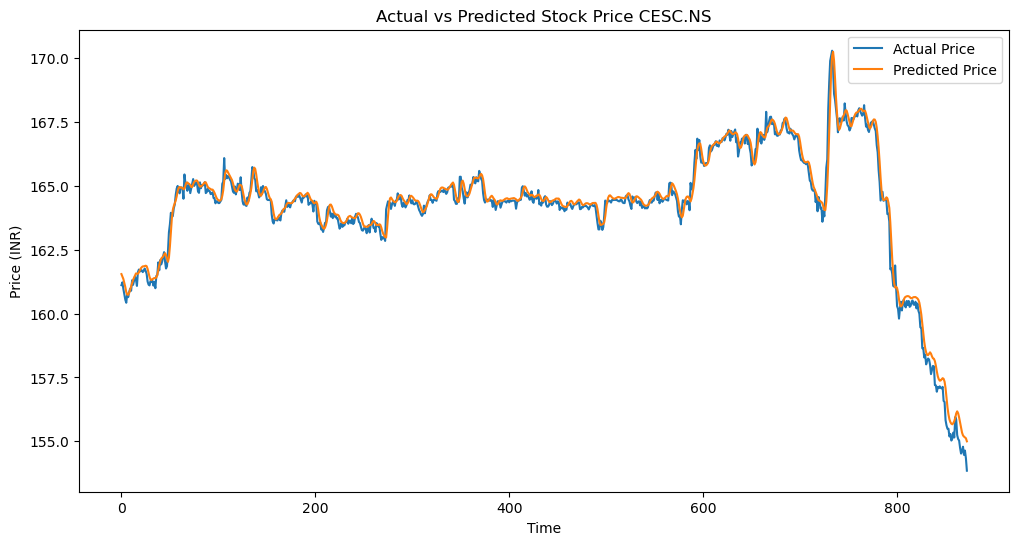

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label="Actual Price")
plt.plot(y_pred_inv, label="Predicted Price")
plt.title(f"Actual vs Predicted Stock Price {symbol}")
plt.xlabel("Time")
plt.ylabel("Price (INR)")
plt.legend()
plt.show()

In [36]:
# --- 1. User Input for Forecast Period ---
try:
    forecast_minutes = int(input("Enter the number of minutes to forecast (e.g., 15, 30, 60): "))
    if forecast_minutes <= 0:
        raise ValueError
except ValueError:
    print("Invalid input. Please enter a positive number. Defaulting to 30 minutes.")
    forecast_minutes = 30

In [38]:
# Since data interval is 5 minutes, calculate the number of steps to predict
future_steps = int(forecast_minutes / 5)
print(
    f"Forecasting for {forecast_minutes} minutes, which is {future_steps} 5-minute steps."
)

# --- 1. Dynamically Determine Feature Count and Close Index ---
# This is the most reliable way to get the number of features.
n_features = scaled_data.shape[1] 

# Get the numerical index of the 'Close' column from the list of scaled columns.
# Assumes your scaled columns are ['Open', 'High', 'Low', 'Close', 'Volume'] or similar.
# For Nifty, this will correctly find 'Close' at index 3.
numeric_cols = ["Open", "High", "Low", "Close", "Volume"]
# Filter to only columns that actually exist in the dataframe
cols_to_scale = [col for col in numeric_cols if col in data.columns]
close_idx = cols_to_scale.index('Close')

print(f"Data has {n_features} features. 'Close' column is at index {close_idx}.")


# --- 2. Dynamic Forecasting Logic ---
lookback = time_steps  # e.g., 60
last_sequence = scaled_data[-lookback:].copy()
forecast_predictions = []

# Assuming 'future_steps' is already defined
for _ in range(future_steps):
    # Reshape using the dynamic n_features
    X_input = np.reshape(last_sequence, (1, lookback, n_features))
    
    # Get prediction
    pred_scaled = model.predict(X_input, verbose=0)[0, 0]
    forecast_predictions.append(pred_scaled)

    # Create the next input row
    next_input_row = last_sequence[-1].copy()
    # Update the 'Close' price at its correct index
    next_input_row[close_idx] = pred_scaled
    
    # Append the new row and shift the sequence
    last_sequence = np.append(last_sequence[1:], [next_input_row], axis=0)


# --- 3. Dynamic Inverse Transform ---
# Create a dummy array with the correct number of features
forecast_transformed = np.zeros((len(forecast_predictions), n_features))

# Place the scaled predictions into the correct 'Close' price column
forecast_transformed[:, close_idx] = forecast_predictions

# Inverse transform to get the actual price values
forecast_prices = scaler.inverse_transform(forecast_transformed)[:, close_idx]


# --- 4. Generate Timestamps and Display ---
# Ensure you use the correct timestamp column ('Date' or 'Datetime')
last_timestamp = data["Datetime"].iloc[-1]
future_timestamps = pd.to_datetime(
    [last_timestamp + pd.DateOffset(minutes=5 * (i + 1)) for i in range(future_steps)]
)

forecast_df = pd.DataFrame(
    {"Timestamp": future_timestamps, "Predicted Close": forecast_prices}
)
print(f"\nPredicted Closing Prices for the Next {forecast_minutes} Minutes:")
print(forecast_df)


# --- 4. Enhanced Visualization ---
# plt.figure(figsize=(15, 7))

# Plot recent historical data using the actual datetime index
# plt.plot(
#     data["Datetime"].iloc[-200:],
#     data["Close"].iloc[-200:],
#     label="Historical Close Price",
#     color="blue",
# )

# Plot the forecasted data with future timestamps
# plt.plot(
#     forecast_df["Timestamp"],
#     forecast_df["Predicted Close"],
#     label="Forecasted Close Price",
#     color="red",
#     marker="o",
#     linestyle="--",
# )

# plt.title(f"Actual vs. Forecasted Stock Price for {symbol}")
# plt.xlabel("Date and Time")
# plt.ylabel("Price (INR)")
# plt.legend()
# plt.grid(True)

# Format the x-axis to show dates and times nicely
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
# plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
# plt.gcf().autofmt_xdate()  # Rotates the dates for better readability

# plt.show()

Forecasting for 60 minutes, which is 12 5-minute steps.
Data has 4 features. 'Close' column is at index 3.

Predicted Closing Prices for the Next 60 Minutes:
             Timestamp  Predicted Close
0  2025-08-28 15:30:00       154.833026
1  2025-08-28 15:35:00       154.754211
2  2025-08-28 15:40:00       154.748769
3  2025-08-28 15:45:00       154.790152
4  2025-08-28 15:50:00       154.855359
5  2025-08-28 15:55:00       154.926927
6  2025-08-28 16:00:00       154.993047
7  2025-08-28 16:05:00       155.046911
8  2025-08-28 16:10:00       155.085734
9  2025-08-28 16:15:00       155.109591
10 2025-08-28 16:20:00       155.120402
11 2025-08-28 16:25:00       155.121034
